## Setup

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
import os
squeezenet_model_path = '../SqueezeNet/SqueezeNet_v1.1/'
if os.path.isfile(squeezenet_model_path + 'squeezenet_v1.1.caffemodel'):
    print('SqeeuzeNet found.')
else:
    print('Could not find SqueezeNet.')

SqeeuzeNet found.


In [4]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

model_def = squeezenet_model_path + 'deploy.prototxt'
model_weights = squeezenet_model_path + 'squeezenet_v1.1.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


## Forward pass on example image

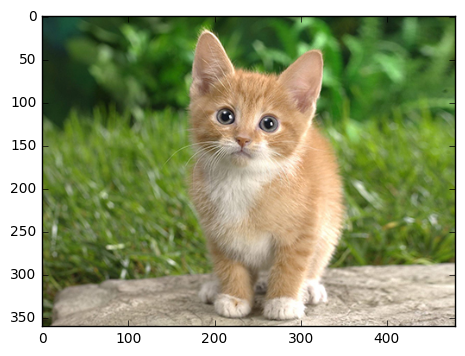

In [6]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [7]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = np.squeeze(output['prob'][0])  # the output probability vector for the first image in the batch

print 'predicted class is: {}, {}% certainty'.format(output_prob.argmax(), max(output_prob)*100)

predicted class is: 281, 27.9458075762% certainty


In [8]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


In [9]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.27945808, 'n02123045 tabby, tabby cat'),
 (0.26872554, 'n02123159 tiger cat'),
 (0.17134129, 'n02119789 kit fox, Vulpes macrotis'),
 (0.084043555, 'n02124075 Egyptian cat'),
 (0.077658229, 'n02085620 Chihuahua')]

## Direct Visualization of Activations

We don't visualize the filter weights directly here since they are 3x3, and can only be applied to the first conv layer anyway.

In [10]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(10, 3, 227, 227)
conv1	(10, 64, 113, 113)
pool1	(10, 64, 56, 56)
fire2/squeeze1x1	(10, 16, 56, 56)
fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_0	(10, 16, 56, 56)
fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_1	(10, 16, 56, 56)
fire2/expand1x1	(10, 64, 56, 56)
fire2/expand3x3	(10, 64, 56, 56)
fire2/concat	(10, 128, 56, 56)
fire3/squeeze1x1	(10, 16, 56, 56)
fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_0	(10, 16, 56, 56)
fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_1	(10, 16, 56, 56)
fire3/expand1x1	(10, 64, 56, 56)
fire3/expand3x3	(10, 64, 56, 56)
fire3/concat	(10, 128, 56, 56)
pool3	(10, 128, 28, 28)
fire4/squeeze1x1	(10, 32, 28, 28)
fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_0	(10, 32, 28, 28)
fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_1	(10, 32, 28, 28)
fire4/expand1x1	(10, 128, 28, 28)
fire4/expand3x3	(10, 128, 28, 28)
fire4/concat	(10, 256, 28, 28)
fire5/squeeze1x1	(10, 32, 28, 28)
fire5/squeeze1x1_fire5/relu_squeeze1x1_0_split_0	(10, 32, 28, 28)
fire5/squeeze1

In [11]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    if data.max() - data.min():
        data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

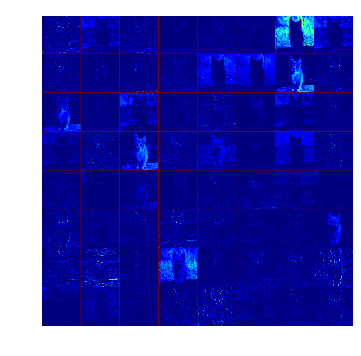

In [12]:
feat = net.blobs['conv1'].data[0]
vis_square(feat)

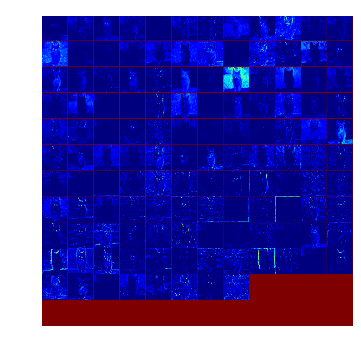

In [13]:
feat = net.blobs['fire2/concat'].data[0]
vis_square(feat)

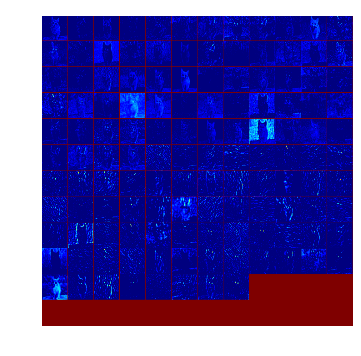

In [14]:
feat = net.blobs['fire3/concat'].data[0]
vis_square(feat)

## Visualization via maximizing gradients w.r.t. certain filter

In [15]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [16]:
net_fn   = model_def
param_fn = model_weights

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [51]:
def objective_L2(dst, filter_num):
    dst.diff[:,filter_num] = dst.data[:,filter_num]

def make_step(net, layer='pool10', filter_num=0, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[layer]
            
    net.forward(end=layer)
    objective(dst, filter_num)  # specify the optimization objective
    net.backward(start=layer)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += 1/np.abs(g).mean() * g
            
    bias = net.transformer.mean['data']
    src.data[:] = np.clip(src.data, -bias, 255-bias)

In [52]:
def visualize_layers(layers):
    for layer in layers:
        num_filters = net.blobs[layer].data.shape[1]
        this_filters = np.random.choice(range(num_filters), min((num_filters + 5) // 10, 10), replace=False)
        for filter_num in this_filters:
            print(filter_num)
            img = np.float32(np.empty((128, 128, 3)))
            for i in range(128):
                for j in range(128):
                    img[i][j][0] = 104. + 20*np.ran
                    img[i][j][1] = 116.
                    img[i][j][2] = 122.
            base = preprocess(net, img)
            src = net.blobs['data']
            src.reshape(1, 3, 128, 128)
            src.data[0] = base
            for _ in range(20):
                make_step(net, layer=layer, filter_num=filter_num)
            print('{}, filter {}:'.format(layer, filter_num))
            showarray(deprocess(net, src.data[0]))

32
conv1, filter 32:


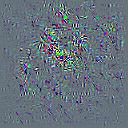

29
conv1, filter 29:


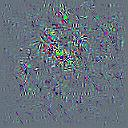

28
conv1, filter 28:


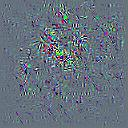

35
conv1, filter 35:


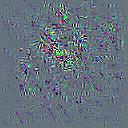

26
conv1, filter 26:


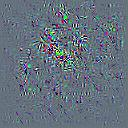

23
conv1, filter 23:


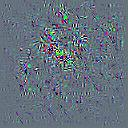

In [53]:
visualize_layers(['conv1'])

fire2/concat, filter 124:


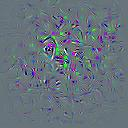

fire2/concat, filter 45:


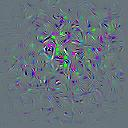

fire2/concat, filter 88:


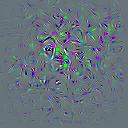

fire2/concat, filter 8:


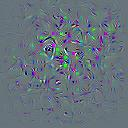

fire2/concat, filter 67:


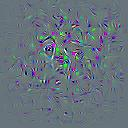

fire2/concat, filter 65:


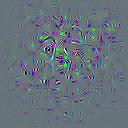

fire2/concat, filter 122:


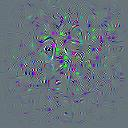

fire2/concat, filter 6:


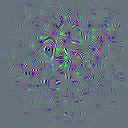

fire2/concat, filter 101:


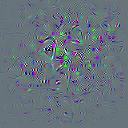

fire2/concat, filter 100:


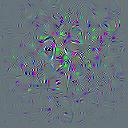

In [47]:
visualize_layers(['fire2/concat'])

fire3/concat, filter 24:


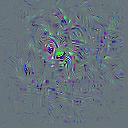

fire3/concat, filter 28:


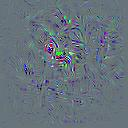

fire3/concat, filter 26:


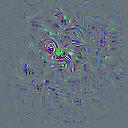

fire3/concat, filter 113:


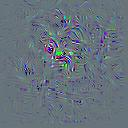

fire3/concat, filter 9:


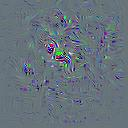

fire3/concat, filter 95:


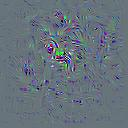

fire3/concat, filter 84:


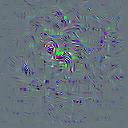

fire3/concat, filter 93:


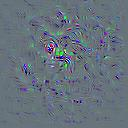

fire3/concat, filter 99:


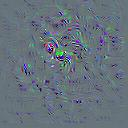

fire3/concat, filter 17:


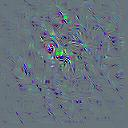

In [48]:
visualize_layers(['fire3/concat'])